In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import layers, metrics
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

Görüntü path'lerini ve label'larını dataframe'e çevirelim.

In [2]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]==".png":
            if dir_name.split()[-1]!="GT":
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))
data =pd.DataFrame(columns=["path","label"])
data["path"]=path
data["label"]=label


In [3]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


X_path ve y değişkenlerini ayıralım.

In [4]:
X_path = data["path"]
y = data["label"]

pathlerdeki görüntüleri okutup array'a çevirelim ve X olarak atayalım.

In [5]:
X =[]
for path in X_path:
    img = image.load_img(path, target_size=(224,224))
    img_array = image.img_to_array(img)
    X.append(img_array)

print(X[0:1])

[array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)]


X y'leri işlemleri rahat yapabilmek adına numpy array'ine dönüştürelim.

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
print(len(X))
print(len(y))

9000
9000


In [8]:
print(X.shape)
print(y.shape)

(9000, 224, 224, 3)
(9000,)


In [9]:
# Görselleri normalize edelim
X = X / 255

In [10]:
#labelları one-hot encode edelim. ilk 3 değeri gözlemleyelim.
y = pd.get_dummies(y).astype(int)
y[0:3]

,Black Sea Sprat,Gilt-Head Bream,Hourse Mackerel,Red Mullet,Red Sea Bream,Sea Bass,Shrimp,Striped Red Mullet,Trout
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0


In [11]:
print(X.shape)
print(y.shape)

(9000, 224, 224, 3)
(9000, 9)


Train, valisayon ve test setleri oluşturalım. Verinin her bir kümeye homojen dağılımı olsun diye shuffle uygulayalım.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5760, 224, 224, 3)
(5760, 9)
(1440, 224, 224, 3)
(1440, 9)


Train setine veri çoğaltma işlemleri uygulayalım. Daha önceden ölçeklendirme yaptığımız için burada rescale parametresini kullanmadık.

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=128)

Model mimarisini oluşturalım.

In [16]:
model = Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Flatten(),
    layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    layers.Dense(9, activation="softmax")]
)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=["accuracy", "AUC"])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               verbose=1,
                               restore_best_weights=True, 
                               mode="min")

model_checkpoint = ModelCheckpoint(filepath='fish_model2.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

In [18]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
         epochs = 100,
         validation_data = (X_val, y_val),
          #batch_size= 128, train generatorde kullandım.
          callbacks =[early_stopping, model_checkpoint]
         )

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729728431.867616      69 service.cc:145] XLA service 0x7ce890009410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729728431.867696      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729728431.867702      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/45 ━━━━━━━━━━━━━━━━━━━━ 20:13 28s/step - AUC: 0.5100 - accuracy: 0.1328 - loss: 3.7727

I0000 00:00:1729728444.167516      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/45 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.5230 - accuracy: 0.1165 - loss: 3.7011
Epoch 1: val_loss improved from inf to 3.61682, saving model to fish_model2.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - AUC: 0.5234 - accuracy: 0.1168 - loss: 3.6983 - val_AUC: 0.4930 - val_accuracy: 0.1035 - val_loss: 3.6168
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.5901 - accuracy: 0.1661 - loss: 3.4615
Epoch 2: val_loss improved from 3.61682 to 3.50201, saving model to fish_model2.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - AUC: 0.5909 - accuracy: 0.1664 - loss: 3.4600 - val_AUC: 0.5139 - val_accuracy: 0.1035 - val_loss: 3.5020
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.6400 - accuracy: 0.2117 - loss: 3.3548
Epoch 3: val_loss improved from 3.50201 to 3.44642, saving model to fish_model2.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - AUC: 0.6403 - accuracy: 0.2117 - loss: 3.3544 - val_AUC: 0.5590 - val_accuracy: 0.1229 - val_loss: 3.4464
Epoch 4/100
44/45 ━━━━━

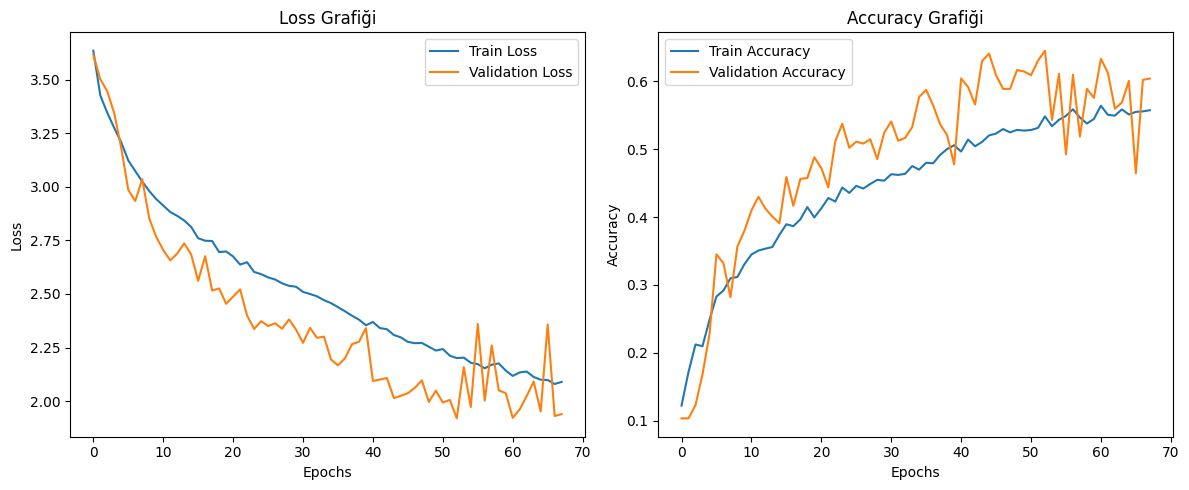

In [19]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
val_loss, val_accuracy, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 1.9194093942642212
Accuracy: 0.6451388597488403
AUC: 0.9464741945266724


In [21]:
# Test seti üzerinde tahmin yapalım.
y_pred = model.predict(X_test)

# En yüksek olasılığı bulup sınıf indeksine çevirelim.
y_pred_classes = y_pred.argmax(axis=-1)

# Gerçek etiketler one-hot encode edilmiş halde, bu yüzden onları da sınıf indekslerine dönüştürelim.
y_test = np.array(y_test) # test seti ile tahmin sunuçlarının veri tipi farklı olduğu için test setini de np array'e çevirelim.
y_test_classes = y_test.argmax(axis=-1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Çok sınıflı sınıflandırma için precision, recall, F1 score hesaplama average="weighted" ifadesi ile sınıf dağılımlarına göre ağırıklı ort. alır. 
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')
print(f'Weighted F1 Score: {f1}')

Weighted Precision: 0.6672018549927665
Weighted Recall: 0.6544444444444445
Weighted F1 Score: 0.6388743248902288
